In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.warp import transform_bounds

# Water Mask

In [2]:
data_path = Path('data')
out_path = Path('out')
out_path.mkdir(exist_ok=True)

In [3]:
with rasterio.open(data_path/'stamen_terrain_12.tif') as ds:
    arr = ds.read().transpose([1, 2, 0])[..., :3]
    bounds = ds.bounds
    profile = ds.profile
    src_crs = str(ds.crs).lower()
src_crs

'epsg:3857'

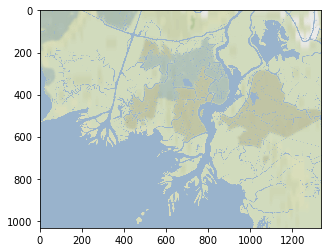

In [4]:
plt.imshow(arr)

In [5]:
arr[-1, 0, :]

array([153, 179, 204], dtype=uint8)

In [6]:
def obtain_mask_from_color(arr, rgb_fixed, tol=3):
    X = arr.astype(float)
    mask_r = (np.abs(X[..., 0] - rgb_fixed[0]) < tol)
    mask_g = np.abs(X[..., 1] - rgb_fixed[1]) < tol
    mask_b = np.abs(X[..., 2] - rgb_fixed[2]) < tol
    return mask_r & mask_g & mask_b

In [7]:
mask = obtain_mask_from_color(arr, [153, 179, 204])

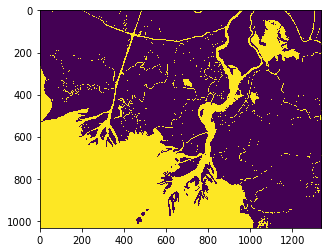

In [8]:
plt.imshow(mask)

In [9]:
profile['count'] = 1
with rasterio.open(out_path/'water_mask.tif', 'w', **profile) as ds:
    ds.write(mask.astype(np.uint8), 1)

# Initialization Mask

We use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943). Update the path accordingly.

In [10]:
water_body_shapefile = '/Volumes/BigData/river_data/hydropolys'

We use rasterio to convert the bounds above (which are in `epsg:3857`) to `epsg:4326`.

In [11]:
bounds_4326 = transform_bounds(src_crs, 'epsg:4326', *bounds)
bounds_4326

(-91.54439999999997, 29.374499999999955, -91.08609999999997, 29.68319999999997)

In [12]:
oceanline_df = gpd.read_file(water_body_shapefile, bbox=bounds_4326).to_crs({'init':'epsg:3857'})
oceanline_df = oceanline_df[oceanline_df['TYPE'] == 'Ocean or Sea'].copy()

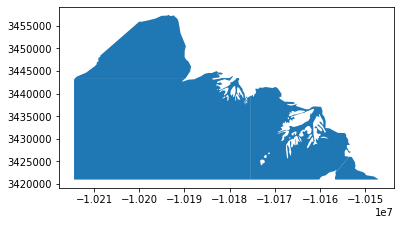

In [13]:
oceanline_df.plot()

This is a wrapper for the rasterize function in `rasterio`.

In [14]:
def translate_one(geometry, profile):
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

The `hydropolys` are cut into squares so we do a minimal buffer to ensure there is no lines that are left out.

In [15]:
ocean_geometry = oceanline_df.geometry.unary_union.buffer(1e-9)

In [16]:
ocean_mask = translate_one(ocean_geometry, profile)

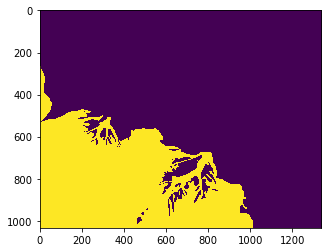

In [17]:
plt.imshow(ocean_mask)

In [18]:
with rasterio.open(out_path/'ocean_mask.tif', 'w', **profile) as ds:
    ds.write(ocean_mask.astype(np.uint8), 1)